<a href="https://colab.research.google.com/github/benjaminnigjeh/keyProteoforms/blob/main/similarity_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import external libraries

In [16]:
import hashlib
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(42)
tf.random.set_seed(42)
random.seed(100)

#Helper Functions

In [17]:
class MinHash:
    def __init__(self, num_hashes=100):
        self.num_hashes = num_hashes
        self.seeds = [random.randint(0, 2**32 - 1) for _ in range(num_hashes)]

    def _hash(self, x, seed):
        return int(hashlib.md5((str(seed) + x).encode('utf8')).hexdigest(), 16)

    def compute(self, set_data):
        min_hashes = [min(self._hash(el, seed) for el in set_data) for seed in self.seeds]
        return min_hashes

    def jaccard_similarity(self, set1, set2):
        min_hash1 = self.compute(set1)
        min_hash2 = self.compute(set2)
        return sum(1 for a, b in zip(min_hash1, min_hash2) if a == b) / self.num_hashes


def hashing(str1, str2):

    n = 3
    set1 = {str1[i:i+n] for i in range(len(str1) - n + 1)}
    set2 = {str2[i:i+n] for i in range(len(str2) - n + 1)}
    minhash = MinHash(num_hashes=100)
    similarity = minhash.jaccard_similarity(set1, set2)
    return(1 - similarity)

def plot_distribution(data):
    if isinstance(data, list):
        data = np.array(data)

    plt.figure(figsize=(10, 6))

    sns.histplot(data, bins=30, kde=True, color='blue', alpha=0.6, stat='density')

    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution of Numbers')

    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
  y_true = [0 if x < 0.5 else 1 for x in y_test]
  y_pred = [0 if x < 0.5 else 1 for x in model.predict(X_test)]

  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

#Import databank

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_hdf("/content/drive/MyDrive/databank_updated", key="databank")

Mounted at /content/drive


In [4]:
df.columns

Index(['sample_name', 'group_name', 'sample_prep', 'scan', 'scan_type',
       'retntion time', 'm/z', 'cast spectra', 'sequence', 'MASS',
       'Uniprot ID', 'Accession'],
      dtype='object')

In [6]:
id = []
sequence = []
cast = []

for i in range(0, len(df['scan'])):
    if df['scan_type'][i] == 'MS2':
        if df['Uniprot ID'][i] != 'None':
            id.append(df['Uniprot ID'][i])
            sequence.append(df['sequence'][i])
            cast.append(df['cast spectra'][i])

ref_seq = 'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA'

#Reshape training dataset

In [8]:
cast_flat = []
hash = []

for i in range(0, len(sequence)):
    cast_flat.append(cast[i])
    hash.append(hashing(sequence[i], ref_seq))

X = np.array(cast_flat)
y = np.array(hash)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


#Train neural network model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(1600,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Test Loss (MSE): {test_loss:.4f}")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1704 - mae: 0.3994 - val_loss: 0.0823 - val_mae: 0.2209
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0723 - mae: 0.1903 - val_loss: 0.0694 - val_mae: 0.1503
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0596 - mae: 0.1381 - val_loss: 0.0656 - val_mae: 0.1396
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0539 - mae: 0.1267 - val_loss: 0.0583 - val_mae: 0.1313
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0460 - mae: 0.1161 - val_loss: 0.0477 - val_mae: 0.1174
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0369 - mae: 0.1041 - val_loss: 0.0366 - val_mae: 0.1054
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0276 - mae: 0.0929 - val_loss: 0.0274 - val_mae: 0.0882
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0201 - mae: 0.0770 - val_loss: 0.0218 - val_mae: 0.0744
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0151 - mae: 0.0644 - 

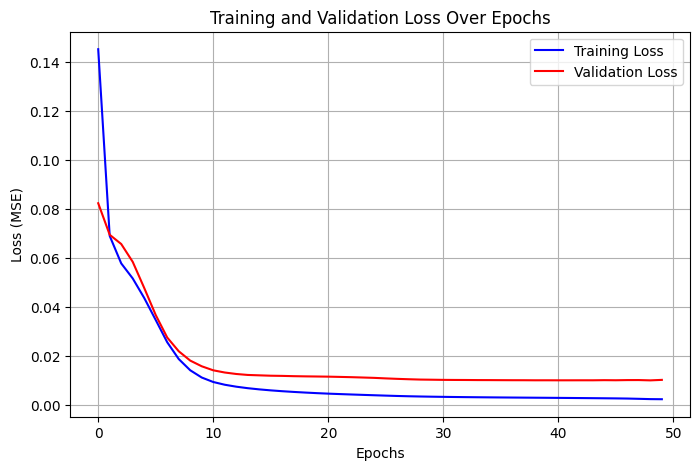

In [26]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(1600,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model and store training history
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_split=0.2)

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss:.4f}")

# 🎨 Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


#Performace evaluation by confusion matrices

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


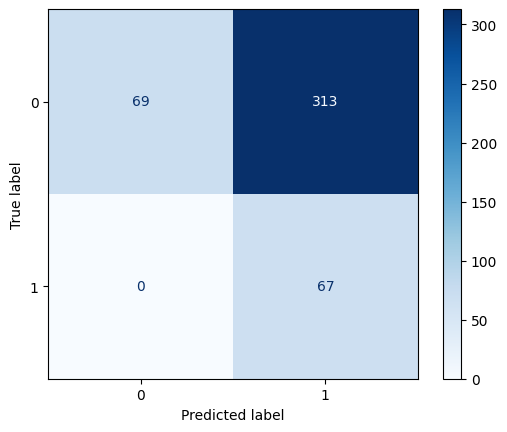

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test):
    # Ensure y_test is binary (0 or 1)
    y_test = np.array(y_test).astype(int)  # ✅ Convert to integer if needed

    # Get model predictions
    y_scores = model.predict(X_test)

    # Convert predictions to binary labels
    y_pred = (y_scores >= 0.5).astype(int).flatten()  # ✅ Convert float → int

    # Ensure shapes match
    if y_test.shape != y_pred.shape:
        print(f"Shape mismatch: y_test {y_test.shape}, y_pred {y_pred.shape}")
        y_test = y_test.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)

    # Show the plot
    plt.show()

# Call the function
plot_confusion_matrix(model, X_test, y_test)
